<hr style="height:10px"> 
 
<div class='container2'>
		<div>
			<img src="C:\Users\leonardo\Downloads\projetoo\shutterstock_1614836437.jpg"' ALIGN='left' style='width:10em'>
		</div>	
	<div style='padding: 0 7em 2em 12em;'>
	<h1>Projeto LIA 1-Temperatura interna do motor (pm) </h1>
	<div style="font-size:12pt;float:left;"> 2025/2 | 46M34 | Sala 200 CAE</div><br><br>
    <div style="font-size:12pt;float:left;"><b>Projetos de Inteligência Artificial - Análise Exploratória de Dados </b></div>
	</div>
</div>


 <hr style="height:5px"> 

    
<h2>Aula 11 - Introdução à Ciência de Dados - <a href="https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature">Electric Motor Temperature Dataset</a> </h2>
Este notebook 
Notebook desenvolvido por: Leonardo Felix</a>

 <hr style="height:2px"> 

### Análise do Conjunto de Dados do Motor Elétrico PMSM

Este conjunto de dados é proveniente de ensaios experimentais de um motor elétrico PMSM (*Permanent Magnet Synchronous Motor*). O objetivo principal é prever a temperatura do ímã permanente (pm), que é a variável alvo. 

---

### Variáveis Medidas

* **u_d, u_q**: Componentes da tensão do motor no referencial dq.
* **i_d, i_q**: Componentes da corrente do motor.
* **motor_speed**: Velocidade de rotação do motor.
* **torque**: Torque aplicado.
* **ambient, coolant**: Temperaturas do ambiente e do líquido de refrigeração.
* **stator_yoke, stator_winding, stator_tooth**: Temperaturas medidas em diferentes partes do estator (a parte fixa do motor).
* **pm**: Temperatura do ímã permanente (dentro do rotor). **Esta é a variável alvo que se deseja prever.**
* `Em resumo o dataset serve para prever a temperatura interna do motor (pm) a partir de variáveis elétricas, mecânicas e de resfriamento. Isso é útil para monitoramento de condição e prevenção de falhas.`

---
## 1. Bibliotecas Necessárias para o Notebook 

Para este notebook deve se utilizar:

* [`matplotlib`](https://matplotlib.org/) (versão 3.1.3 ou superior): construção e exibição de gráficos variados (estático).
* [`seaborn`](https://seaborn.pydata.org/) (versão 0.10.0 ou superior): construção e exibição de gráficos variados (dinâmicos).
* [`numpy`](https://numpy.org) (versão 1.16.2 ou superior): manipulação de dados em formato de vetores e matrizes.
* [`pandas`](https://pandas.pydata.org/pandas-docs/stable/index.html) (versão 0.24.1 ou superior): manipulação de dados em formato de tabelas.
* [`scikit-learn`](https://scikit-learn.org/stable/)
* [`joblib`](https://joblib.readthedocs.io/en/stable/).
Será utilizado o conjunto de dados que se encontra no diretório `datasets`, em formato de arquivo `.csv .

In [79]:

# ||Importações||
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [80]:
#||Carregar o dataset||

file_path = r"C:\Users\leonardo\Downloads\projetoo\temp\measures_v2.csv"
df = pd.read_csv(file_path)


print("Shape:", df.shape)
print("Colunas:", df.columns)

Shape: (1330816, 13)
Colunas: Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')


In [81]:
#||Exploratória rápida||
print("\n--- Head ---")
print(df.head())


print("\n--- Descrição estatística ---")
print(df.describe().T)


print("\n--- Valores faltantes por coluna ---")
print(df.isnull().sum())


--- Head ---
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17  

--- Descrição estatístic

## 2. Pré-processamento

O pré-processamento consiste em **minimizar ou eliminar problemas existentes no conjunto de dados** e torná-lo mais adequado para análise ou utilização por algoritmos de aprendizado de máquina.

## 2.1 Eliminação de atributos irrelevantes

Algumas colunas do dataset podem **não contribuir para as análises ou para a modelagem**, sendo consideradas irrelevantes. Por exemplo:

- `profile_id`: identifica apenas o experimento ou perfil de medição, mas **não influencia nas variáveis de interesse** como temperatura, torque ou velocidade.
- Outras colunas de identificação ou categóricas que não têm relação direta com as medições podem ser descartadas.

Remover atributos irrelevantes **reduz a complexidade do modelo**, **evita ruído** e **melhora o desempenho** de algoritmos de aprendizado de máquina.

> *Observação:* Em cenários reais, muitas vezes é necessário consultar especialistas em engenharia de motores para identificar quais variáveis são realmente relevantes para a análise.


In [82]:
# ||VERIFICAÇÃO DE VALORES AUSENTES||
# verifica quais linhas possuem pelo menos um valor ausente (NaN)
idxRowNan = df[df.isnull().any(axis=1)].index

# se existirem linhas com NaN, exibe
if len(idxRowNan) > 0:
    print(f"Existem {len(idxRowNan)} linha(s) com valores ausentes:")
    display(df.loc[idxRowNan])
else:
    print("Não existem valores ausentes no dataset! ✅")


Não existem valores ausentes no dataset! ✅


In [84]:
#||TRATAMENTO DOS VALORES AUSENTES||
# Função para tratar valores ausentes
def trataFaltantes(df):
    """
    Substitui valores NaN em todas as colunas numéricas pela média da coluna.
    Retorna o DataFrame atualizado e um dicionário com os índices das linhas que tinham NaN.
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    idx_nan_dict = {}

    for col in numeric_cols:
        idx_nan = df[df[col].isna()].index
        if len(idx_nan) > 0:
            media = df[col].mean()
            df.loc[idx_nan, col] = media
            idx_nan_dict[col] = idx_nan

    return df, idx_nan_dict

# Aplicar a função ao dataset já carregado
df, idx_nan_dict = trataFaltantes(df)

# Exibir linhas que tinham NaN
if idx_nan_dict:
    print('\nObjetos com valores nulos substituídos pela média:')
    for col, idx in idx_nan_dict.items():
        print(f'\nColuna: {col}')
        display(df.loc[idx])
else:
    print("Não existem valores ausentes no dataset! ✅")



Não existem valores ausentes no dataset! ✅


In [85]:
# ||VERIFICAÇÃO DE VALORES REDUNDANTES E INCONSISTENTES COMO VALORES DUPLICADOS||
# define as colunas que serão usadas para verificar duplicatas
cols_to_check = ['ambient', 'coolant', 'stator_winding', 'stator_tooth', 'torque', 'motor_speed']

# obtém apenas os registros duplicados nessas colunas
df_duplicates = df[df.duplicated(subset=cols_to_check, keep=False)]

# se houver valores redundantes ou inconsistentes, imprima
if len(df_duplicates) > 0:
    print('\nObjeto(s) redundante(s) e/ou inconsistente(s):')
    display(df_duplicates)
else:
    print('Não existem objetos redundantes e/ou inconsistentes!')



Não existem objetos redundantes e/ou inconsistentes!


In [90]:
        #||TRATAMENTO DOS VALORES INCONSISTENTES||
            #Remove linhas duplicadas do DataFrame, mantendo apenas a primeira ocorrência.
            
        def delDuplicatas(df):
             
            # armazena o número de linhas antes da remoção
            n_before = len(df)
            
            # remove duplicatas, mantendo a primeira ocorrência
            df = df.drop_duplicates(keep='first')
            
            # imprime quantas duplicatas foram removidas
            n_after = len(df)
            print(f'Duplicatas removidas: {n_before - n_after}')
            
            return df
        
        # aplica a função ao dataset já carregado
        df = delDuplicatas(df)

Duplicatas removidas: 0


In [91]:

# define as colunas para verificar inconsistências/duplicatas
cols_to_check = ['ambient', 'coolant', 'stator_winding', 'stator_tooth', 'torque', 'motor_speed']

def delInconsistencias(df):
    """
    Remove todas as linhas duplicadas nessas colunas, mantendo apenas registros únicos.
    """
    df = df.drop_duplicates(subset=cols_to_check, keep=False)
    return df

# aplica a função ao dataset já carregado
df = delInconsistencias(df)

# verifica se ainda existem duplicatas
df_duplicates = df[df.duplicated(subset=cols_to_check, keep=False)]

if len(df_duplicates) > 0:
    print('Registro(s) redundante(s) ou inconsistente(s) encontrados:')
    display(df_duplicates)
else:
    print('Não existem registros redundantes e/ou inconsistentes! :)')


Não existem registros redundantes e/ou inconsistentes! :)


---
## 3. Detecção de outliers (valor atípico)
Outro passo importante na análise e tratamento dos dados é a detecção de outliers (dados gerados por leituras incorretas, erros de digitação etc).

`Gráfico Box Plot`

Uma das maneiras mais simples de verificar se os dados contém outliers.

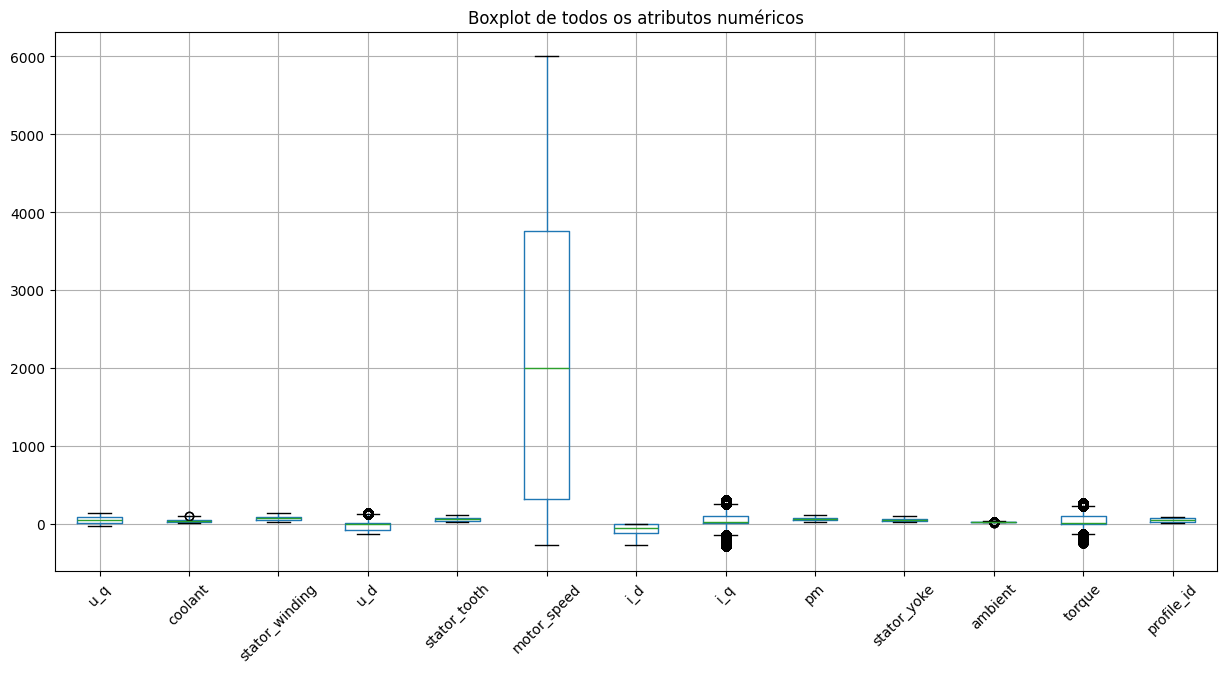

In [92]:

# gerar um boxplot para cada atributo numérico
df.boxplot(figsize=(15,7))
plt.title("Boxplot de todos os atributos numéricos")
plt.xticks(rotation=45)  # rotaciona os nomes das colunas se forem longos
plt.show()


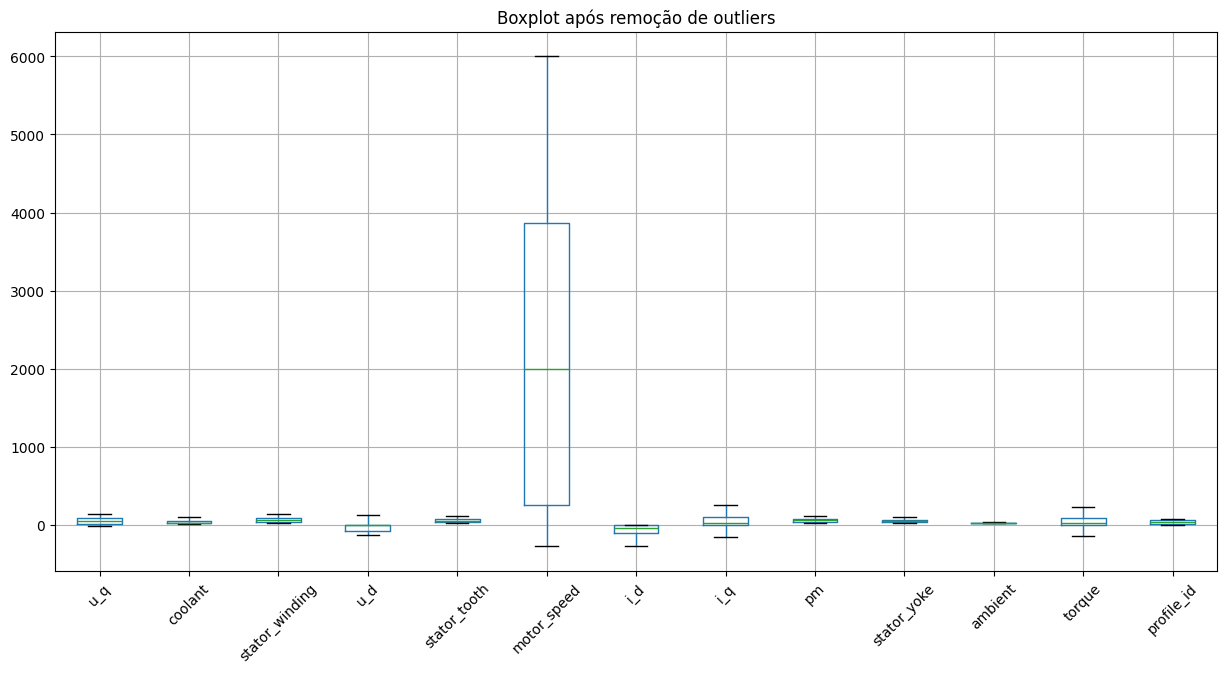

In [97]:
# Remove outliers de todas as colunas numéricas do DataFrame usando o método IQR

def removeOutliers(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    for atributo in numeric_cols:
        # calcula o primeiro e terceiro quartil
        q25 = df[atributo].quantile(0.25)
        q75 = df[atributo].quantile(0.75)
        IQR = q75 - q25
        
        # filtra o DataFrame mantendo apenas os valores dentro do limite do IQR
        df = df[(df[atributo] >= (q25 - 1.5 * IQR)) & (df[atributo] <= (q75 + 1.5 * IQR))]
    
    return df

# remove os outliers
df = removeOutliers(df)

# apresenta as principais estatísticas da base de dados
df.boxplot(figsize=(15,7))
plt.title("Boxplot após remoção de outliers")
plt.xticks(rotation=45)
plt.show()


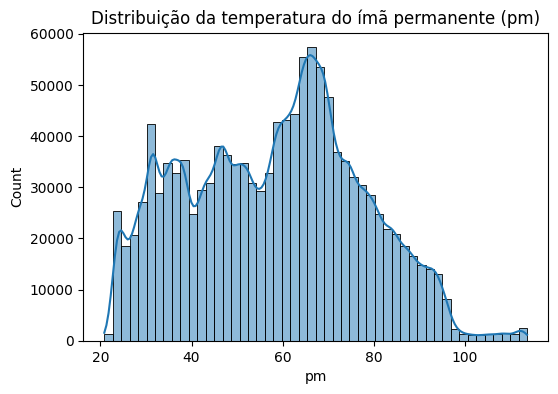

In [98]:
# Histograma do target (pm)
plt.figure(figsize=(6,4))
sns.histplot(df["pm"], bins=50, kde=True)
plt.title("Distribuição da temperatura do ímã permanente (pm)")
plt.show()

In [99]:
#  ||Feature Engineering||
# Criar magnitude de tensão e corrente
df["u_mag"] = np.sqrt(df["u_d"]**2 + df["u_q"]**2)
df["i_mag"] = np.sqrt(df["i_d"]**2 + df["i_q"]**2)


# Definir X e y
X = df.drop(columns=["pm"]) # removendo target
y = df["pm"]

In [100]:
#||Divisão treino/teste||
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)


print("Treino:", X_train.shape, "Teste:", X_test.shape)

Treino: (1010280, 14) Teste: (252570, 14)


In [101]:
# ||Modelos (pipelines)||
pipe_lr = Pipeline([
("scaler", StandardScaler()),
("reg", LinearRegression())
])


pipe_ridge = Pipeline([
("scaler", StandardScaler()),
("reg", Ridge(alpha=1.0, random_state=42))
])


pipe_rf = Pipeline([
    # ("scaler", StandardScaler()),  # opcional, pode deixar comentado
    ("reg", RandomForestRegressor(
        n_estimators=10,       # menos árvores
        max_depth=5,           # mais raso
        max_features='sqrt',   # menos features por split
        n_jobs=-1,             # usa todos os núcleos
        random_state=42
    ))
])


---
## 4 Otimização devido ao tamanho do dataset
Devido ao tamanho do dataset, dataset do Kaggle Electric Motor Temperature tem mais de 2 milhões de registros para exigir menos hardware, no entanto caso tiver melhor hardware na sua maquina tem a possibilidade de aumentar a quantidade de dados, consequentemente a precisão.

In [102]:
#Pegando uma amostragem do dataset devido ao hardware
df_sample = df.sample(50_000, random_state=42)  

In [103]:
#Diminuindo o Random Forest
modelo_rf = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42, n_jobs=-1)


In [104]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


---
## 5 Treinamento e avaliação do modelo


In [105]:
# || Treinamento e avaliação ||
def avaliar_modelo(modelo, nome):
    modelo.fit(X_train, y_train)                # indentado
    y_pred = modelo.predict(X_test)             # indentado
    
    mse = mean_squared_error(y_test, y_pred)    # indentado
    rmse = np.sqrt(mse)                         # indentado
    mae = mean_absolute_error(y_test, y_pred)   # indentado
    r2 = r2_score(y_test, y_pred)               # indentado
    
    print(f"\n--- {nome} ---")                  # indentado
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return modelo                               # indentado

# Chamando os modelos
modelo_lr = avaliar_modelo(pipe_lr, "Linear Regression")
modelo_ridge = avaliar_modelo(pipe_ridge, "Ridge")
modelo_rf = avaliar_modelo(pipe_rf, "Random Forest")



--- Linear Regression ---
MSE: 66.8619902075116
RMSE: 8.176918136285309
MAE: 6.155947997014205
R²: 0.8161740551674819

--- Ridge ---
MSE: 50.50201577632717
RMSE: 7.106477029888098
MAE: 5.312068471119445
R²: 0.86115308956228

--- Random Forest ---
MSE: 60.100010843010075
RMSE: 7.752419676656449
MAE: 5.681133500970968
R²: 0.8347649951284319


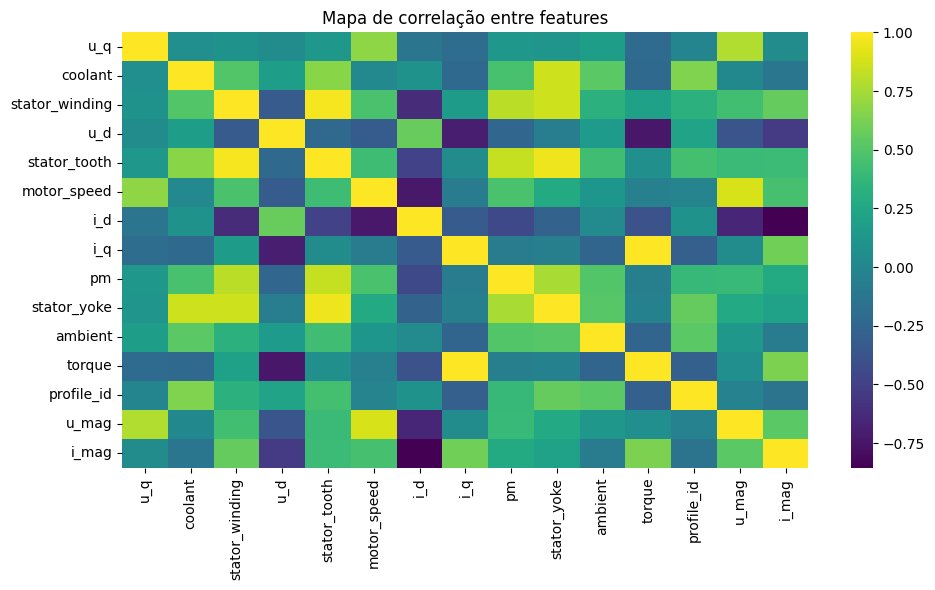

In [106]:
#|| Visualizações-matriz confusão ||
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="viridis", annot=False)
plt.title("Mapa de correlação entre features")
plt.tight_layout()
plt.show()

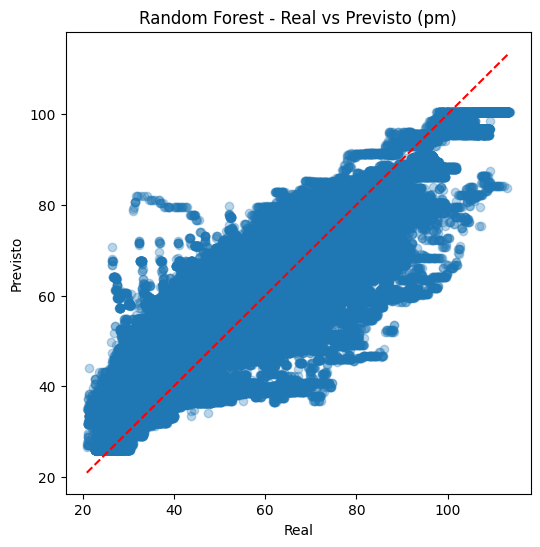

In [107]:
# || Curva real vs predito (Random Forest) ||
y_pred_rf = modelo_rf.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.title("Random Forest - Real vs Previsto (pm)")
plt.show()

Quais parametros possuem maior peso na variação o pm ( temperatura do ímã permanente):


Top 10 features:
stator_yoke       0.331864
stator_tooth      0.301744
profile_id        0.074284
u_mag             0.065020
stator_winding    0.056858
coolant           0.043545
ambient           0.034853
i_mag             0.021433
u_q               0.015708
i_d               0.013684
dtype: float64


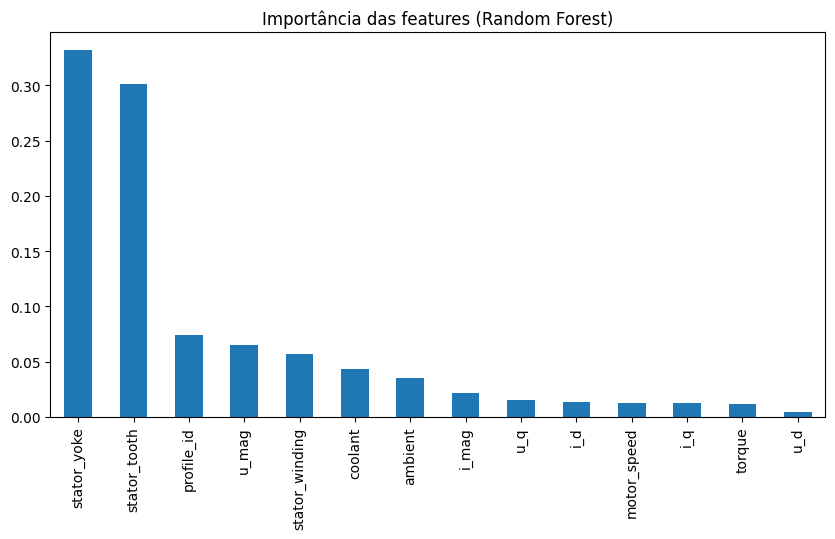

In [108]:
# || Importância de features (Random Forest) ||
importances = modelo_rf.named_steps['reg'].feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features:")
print(feat_imp.head(10))


feat_imp.head(15).plot(kind="bar", figsize=(10,5))
plt.title("Importância das features (Random Forest)")
plt.show()

In [109]:
# || Validação cruzada || para  melhor avaliação do modelo||
scores = cross_val_score(modelo_rf, X, y, cv=3, scoring="r2")
print("\nValidação cruzada R²:", scores)
print("Média:", scores.mean())


Validação cruzada R²: [0.75240758 0.72853444 0.53531847]
Média: 0.6720868330688007


In [110]:
# || Salvar modelo||
model_path = "C:/Users/leonardo/Downloads/projetoo/motor_temp_rf_pipeline.joblib"
joblib.dump(modelo_rf, model_path)
print("\nModelo salvo em:", model_path)


Modelo salvo em: C:/Users/leonardo/Downloads/projetoo/motor_temp_rf_pipeline.joblib


---
## 6 Predição
Predição dos dados: essa célula cria um exemplo médio a partir dos dados de treinamento e usa o seu modelo para prever o resultado para esse exemplo

In [113]:
# || Predição em novos dados ||
novo_exemplo = pd.DataFrame([X.mean()])
print("\nExemplo de dados usado para a previsão:")
print(novo_exemplo)
print("\nPredição para exemplo médio (°C):", pred_pm[0])


Exemplo de dados usado para a previsão:
         u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0  55.555798  35.769113       65.095778 -29.71444     56.054208  2227.130936   

         i_d        i_q  stator_yoke    ambient     torque  profile_id  \
0 -65.826092  44.567603    47.557475  24.519209  37.083525   39.865075   

       u_mag       i_mag  
0  81.173718  100.369282  

Predição para exemplo médio (°C): 61.739366916782636


`Podemos verificar que a temperatura do ímã permanente prevista para os dados exemplos é de:61.74°C`